<a href="https://colab.research.google.com/github/AyaAhmed72/Assign/blob/main/examples/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object detection with Gemini 1.5 Flash

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb"><img src="https://github.com/google-gemini/cookbook/blob/main/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>

### Install dependencies

In [3]:
!pip install -U -q "google-generativeai>=0.7.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
import google.generativeai as genai
from PIL import Image

import io
import os
import requests

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [5]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

## Create a model

In some case you might have to lower the [safety features](../quickstarts/Safety.ipynb), but it should be ok with the examples in this notebook.

In [6]:
model = genai.GenerativeModel(
  model_name='gemini-1.5-flash-002',
)

## Utils

Some plotting and parsing utilities.

In [7]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

In [8]:
# @title RegionSelector utils
# Adapted from https://colab.research.google.com/drive/1bjGbrtjE_Ugc3YpIvQMtkqsiMPqIp89W#scrollTo=02GJS3Zv4JAu  written by Andreas Steiner and Gabriel Antoine le Roux
import base64
import io

import google.colab.output as output
import IPython
import numpy as np
import PIL

bbox_str = None
bbox_hist = ''

def set_bbox_str(x):
  global bbox_str
  global bbox_hist
  bbox_str = x
  bbox_hist += x + '\n'


output.register_callback('set_bbox_str', set_bbox_str)


class RegionSelector:

  def __init__(self, img):
    src = self._img2src(img)
    IPython.display.display(IPython.display.HTML(r"""
    <pre id="stuff">
      <img id="img" src="__SRC__">
    </pre>
    <pre id="pre"></pre>
    <script>
    const img = document.getElementById('img')
    const pre = document.getElementById('pre')
    const stuff = document.getElementById('stuff')
    const boxes = []
    let x0=null, y0=null
    function update(x, y) {
      const x1 = Math.min(x, x0)
      const y1 = Math.min(y, y0)
      const x2 = Math.max(x, x0)
      const y2 = Math.max(y, y0)
      const el = boxes[boxes.length - 1]
      el.style.left = x1 + 'px'
      el.style.top = y1 + 'px'
      el.style.width = (x2 - x1) + 'px'
      el.style.height = (y2 - y1) + 'px'
      const ret = [x1, y1, x2, y2]
      return ret
    }
    img.addEventListener('mousedown', e => {
      const el = document.createElement('div')
      el.style.border = '2px solid red'
      el.style.position = 'absolute'
      stuff.append(el)
      boxes.push(el)
      x0 = e.clientX
      y0 = e.clientY
      update(x0, y0)
      e.stopPropagation()
    })
    window.addEventListener('mousemove', e => {
      if (x0 === null) return
      update(e.clientX, e.clientY)
      e.stopPropagation()
    })
    window.addEventListener('mouseup', e => {
      if (x0 === null) return
      const coords = update(e.clientX, e.clientY)
      const rect = img.getBoundingClientRect();
      let absoluteCoords = [
        coords[0] - rect.left,
        coords[1] - rect.top,
        coords[2] - rect.left,
        coords[3] - rect.top,
        ];
      const bbox_str = JSON.stringify(absoluteCoords)
      pre.textContent += bbox_str + '\n'
      google.colab.kernel.invokeFunction(
        'set_bbox_str', [bbox_str], {})
      x0 = y0 = null
      e.stopPropagation()
    })
    """.replace('__SRC__', src)))

  def _img2src(self, img):
    if isinstance(img, np.ndarray):
      if img.dtype != 'uint8':
        img = (255 * img).astype('uint8')
      img = PIL.Image.fromarray(img)
    f = io.BytesIO()
    img.save(f, format='JPEG')
    s = base64.b64encode(f.getvalue()).decode('ascii')
    return 'data:image/jpg;base64,%s' % s

  def set_image(self, img):
    """Updates image content."""
    google.colab.output.eval_js(
        f'TextImage_set_img({self._img2src(img)})',
        ignore_result=self.ignore_result,
    )

In [9]:
# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))

def postproc_bbox_str(height, width):
 x0, y0, x1, y1 = [float(x) for x in bbox_str.removeprefix('[').removesuffix(']').split(',')]
 x0 = int(np.round(x0 / width * 1000))
 y0 = int(np.round(y0 / height * 1000))
 x1 = int(np.round(x1 / width * 1000))
 y1 = int(np.round(y1 / height * 1000))
 return f'{y0} {x0} {y1} {x1}'

def postproc_bbox_hist(height, width):
  bbox_strs = bbox_hist.rstrip().split("\n")
  results = []
  for bbox_str in bbox_strs:
    x0, y0, x1, y1 = [float(x) for x in bbox_str.removeprefix('[').removesuffix(']').split(',')]
    x0 = int(np.round(x0 / width * 1000))
    y0 = int(np.round(y0 / height * 1000))
    x1 = int(np.round(x1 / width * 1000))
    y1 = int(np.round(y1 / height * 1000))
    results.append(f" (x = {(x0 + x1) // 2}, y = {(y0 + y1)//2}); ")
  return results

## Open vocabulary object detection

In [10]:
from google.colab import files
from PIL import Image
import io

# Upload the image file
uploaded = files.upload()

# Assuming the uploaded file is named 'download (4).png'
image_path = 'download (4).png'

# Open the uploaded image
im = Image.open(image_path)
im.show()

Saving download (4).png to download (4) (2).png


In [11]:
response = model.generate_content([
    im,
    (
        "Return bounding boxes for all the cars in the following format as"
        " a list. \n [ymin, xmin, ymax, xmax]"
    ),
])
print(response.text)

Here are the bounding boxes of the cars in the image.  The format is [ymin, xmin, ymax, xmax].

- [513, 221, 670, 393]
- [511, 196, 600, 254]
- [495, 463, 524, 486]
- [491, 545, 533, 576]
- [496, 615, 544, 658]
- [503, 386, 541, 413]
- [500, 409, 536, 435]
- [496, 581, 518, 600]
- [490, 413, 505, 421]



In [20]:
import re
from google.colab import files
from PIL import Image
import io
import json

# Function to parse bounding boxes from text
def parse_list_boxes(text):
    """
    Parses a string containing bounding boxes and returns a list of boxes.

    Args:
        text: The string containing the bounding boxes.

    Returns:
        A list of bounding boxes, where each bounding box is a list of 4 integers.
    """
    result = []
    # Find all occurrences of 4 numbers separated by spaces or commas
    matches = re.findall(r"\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]", text)
    for match in matches:
        result.append([int(x) for x in match])
    return result


def parse_list_boxes_with_label(text):
    """
    Parses a string containing bounding boxes with labels and returns a dictionary.

    Args:
        text: The string containing the bounding boxes and labels.

    Returns:
        A dictionary where keys are object labels and values are bounding boxes.
    """
    try:
        # Attempt to directly parse the text as JSON
        data = json.loads(text)
        return data
    except json.JSONDecodeError:
        # If direct parsing fails, attempt to extract JSON using regex
        match = re.search(r'\{(.*?)\}', text, re.DOTALL)
        if match:
            json_string = match.group(1)
            # Replace single quotes with double quotes for valid JSON
            json_string = json_string.replace("'", '"')
            try:
                data = json.loads("{" + json_string + "}")
                return data
            except json.JSONDecodeError:
                print("Could not parse JSON data from response.")
                return {}
        else:
            print("No JSON data found in response.")
            return {}

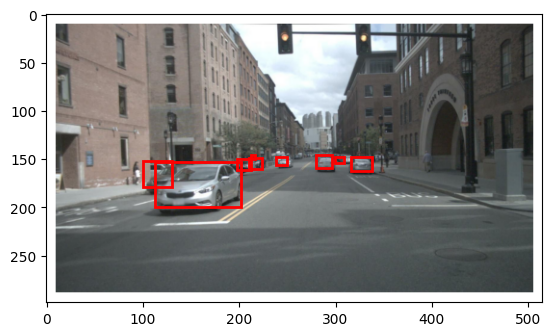

In [24]:
import re
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming the uploaded file is named 'download (4).png'
image_path = 'download (4).png'

# Open the uploaded image
im = Image.open(image_path)

# Use parse_list_boxes function to extract bounding boxes
boxes = parse_list_boxes(response.text)

# Function to plot bounding boxes
def plot_bounding_boxes(image, boxes):  # Modified function signature
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Get image dimensions
    width, height = image.size

    # Add bounding boxes to the image
    for bbox in boxes:  # Iterating through the boxes list
        ymin, xmin, ymax, xmax = bbox

        # Normalize coordinates
        xmin = int(xmin / 1000 * width)
        ymin = int(ymin / 1000 * height)
        xmax = int(xmax / 1000 * width)
        ymax = int(ymax / 1000 * height)

        width_rect = xmax - xmin
        height_rect = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width_rect, height_rect, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Plot the bounding boxes on the image
plot_bounding_boxes(im, boxes) # Passing boxes to the function